In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymongo
import os, sys
root_dir = "/home/cs/Documents/pymarl/src"
sys.path = ['/home/cs/Documents/pymarl/src'] + sys.path

In [2]:
from config import mongodb

In [3]:
from config.mongodb import REGISTRY as mongo_REGISTRY
def get_mongo_db_client(conf_name, maxSevSelDelay=5000):    
    mongo_conf = mongo_REGISTRY[conf_name](None, None)
    db_url = mongo_conf["db_url"]
    db_name = mongo_conf["db_name"]
    client = pymongo.MongoClient(db_url, ssl=True, serverSelectionTimeoutMS=maxSevSelDelay)
    return client, client[db_name]

In [4]:
class MongoCentral():
    
    def __init__(self, *args, **kwargs):
        self.conf_names = kwargs["conf_names"]
        self.db = {}
        self._connect(self.conf_names)
        
    def _connect(self, conf_names):
        self.clients = {}
        for _name in conf_names:
            self.clients[_name], self.db[_name] = get_mongo_db_client(_name)
            
    def get_exp_names(self):
        #print("Loading keys...")
        names = []
        for key, db in self.db.items():
            query = db["runs"].distinct("config.name") # .find({"config":None})
            names.extend(query)
            print("Done Loading...")
        return names
    
    def get_tag_names(self, tag, bundle=True):
        import re
        names = []
        for key, db in self.db.items():            
            query = db.runs.find({"config.name":{'$regex':r'^{}(.*)'.format(tag)}}, {"config.name":1}) # .find({"config":None})
            names.extend([_q["config"]["name"] for _q in query])
            print("Done Loading...")
            
        if bundle: # bundle by experiment name
            bundle_dic = {}
            for name in names:
                tag, exp_name_time_stamp, repeat = name.split("__")
                exp_name = "_".join(exp_name_time_stamp.split("_")[:-1])
                if exp_name not in bundle_dic:
                    bundle_dic[exp_name] = []
                bundle_dic[exp_name].append(name) 
            return bundle_dic
        return names

    def get_name_prop(self, name, prop):
        res = []
        for key, db in self.db.items():
            query = db.runs.find({"config.name":name}, {prop:1})
            for _q in query:
                res.append(_q)
        return res

In [5]:
mongo_central = MongoCentral(conf_names=["gandalf_pymarl"])

In [6]:
import pprint
b = mongo_central.get_tag_names("FOX2")
pprint.pprint(b)

Done Loading...
{'coma_baseline_sc2_2d_3z': ['FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:00:47__repeat1',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:00:47__repeat3',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:00:47__repeat4',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:01:39__repeat1',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:00:47__repeat5',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:01:39__repeat2',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:01:39__repeat3',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:01:39__repeat4',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:02:46__repeat1',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:02:46__repeat2',
                             'FOX2__coma_baseline_sc2_2d_3z_14/05/18-00:02:46__repeat3',
     

In [7]:
def plot_bundle(bundle, mongo_central, prop, mode = ""): # mode: individual, all
    import pandas as pd
    if mode in ["individual"]:
        # make separate plot for each key, showing all subkeys
        df_dict={}
        for _exp, _names in bundle.items():
            episode_rewards_test = []
            t_env_test = []
            dfs = []
            for _i, _name in enumerate(_names):
                ret = mongo_central.get_name_prop(_name, "info.{}".format(prop))                
                ret2 = mongo_central.get_name_prop(_name, "info.T env test")
                try:
                    if ret[0]["info"] != {}:
                        episode_rewards_test.append(ret[0]["info"][prop])
                        t_env_test.append(ret2[0]["info"]["T env test"])
                        min_len = min(len(t_env_test[-1]), len(episode_rewards_test[-1]))
                        df  = pd.DataFrame(data=episode_rewards_test[-1][:min_len], 
                                           columns=["{}{}".format(_exp, _i)], 
                                           index=t_env_test[-1][:min_len])
                        dfs.append(df)
                    else:
                        #episode_rewards_test.append([])
                        #t_env_test.append([])                    
                        pass
                except:
                    continue
                #print(episode_rewards_test)
                #print(t_env_test)
            total_df = pd.concat(dfs)
            total_df.index = total_df.index.astype(int)
            total_df = total_df.sort_index()
            total_df = total_df.groupby(total_df.index).mean()
            try:            
                interpol_df = total_df.interpolate(method="nearest")
                pl = interpol_df.plot(title="Experiment: {}".format(_exp),
                  figsize=(20, 10))
                df_mean = interpol_df.mean(axis=1, skipna=True)
                df_std = interpol_df.std(axis=1, skipna=True)
                df_dict[_name] = interpol_df
            except Exception as e:
                total_df = total_df.fillna(method='bfill')
                pl = total_df.plot(title="Experiment: {}".format(_exp),
                  figsize=(20, 10))
                df_mean = total_df.mean(axis=1, skipna=True)
                df_std = total_df.std(axis=1, skipna=True)
                df_dict[_name] = total_df
                
            plot_std_tube(pl, df_mean, df_std)
            
        return df_dict
            #break
            
    elif mode in ["all"]: 
        # plot all keys on same plot, averaging over subkeys

        pass

def plot_std_tube(pl, df_mean, df_std, color="#EFF9FC"):
    #std = df_std.std(axis=1, skipna=True)
    #mn = df_mean.mean(axis=1, skipna=True)
    df_mean.plot(ax=pl, style='y^-')
    pl.fill_between(df_mean.index, df_mean - df_std,  
                 df_mean + df_std, color=color)


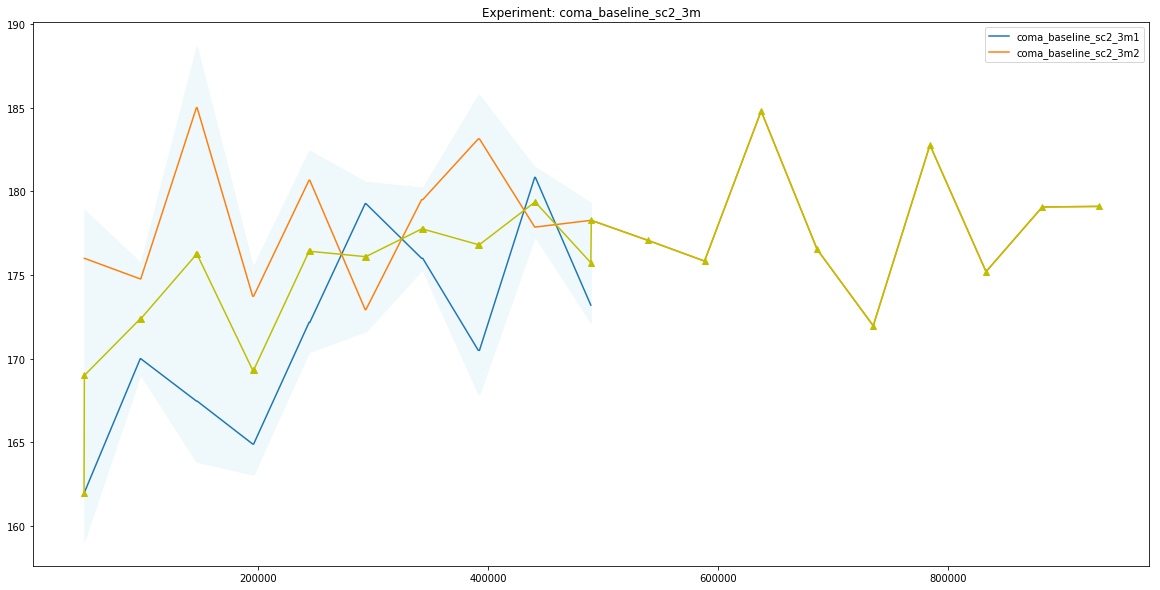

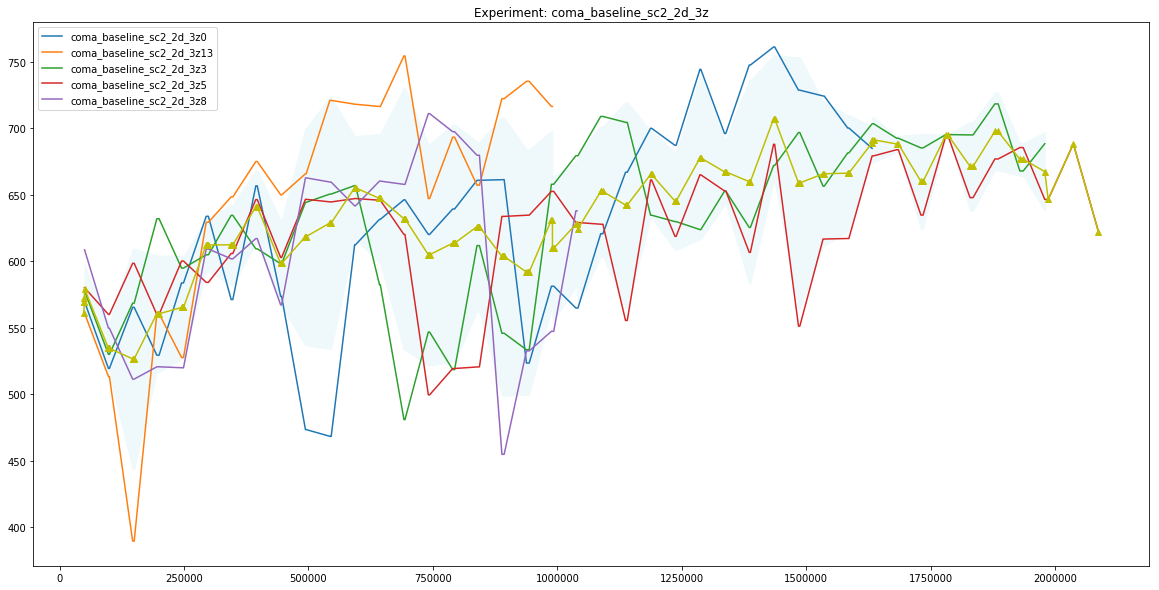

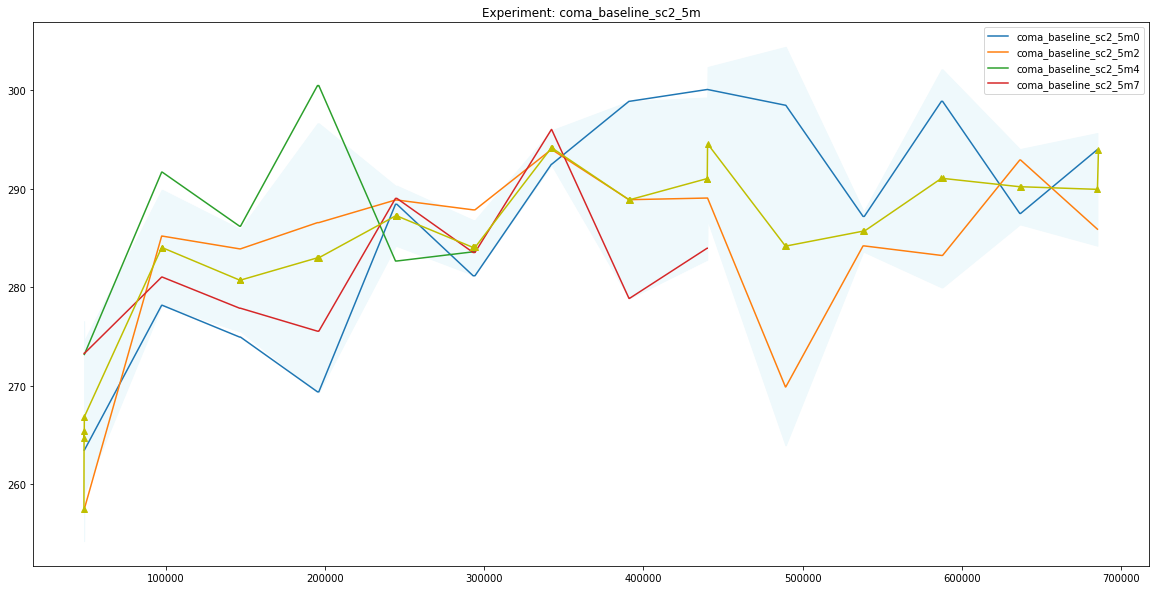

In [8]:
d1 = plot_bundle(b, mongo_central, prop="Episode reward test", mode="individual")

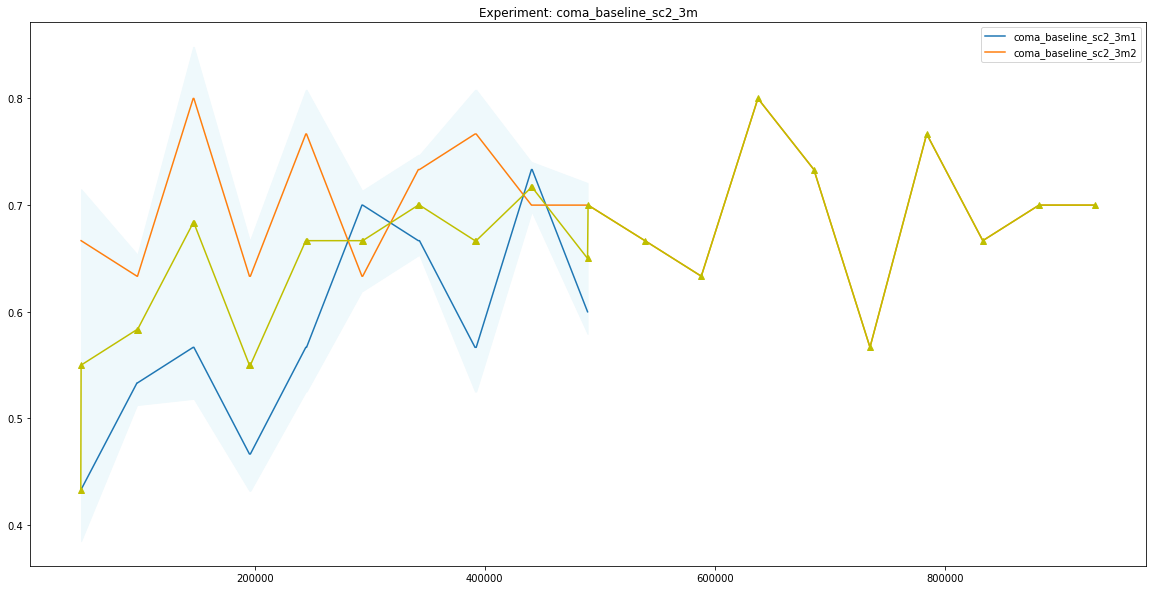

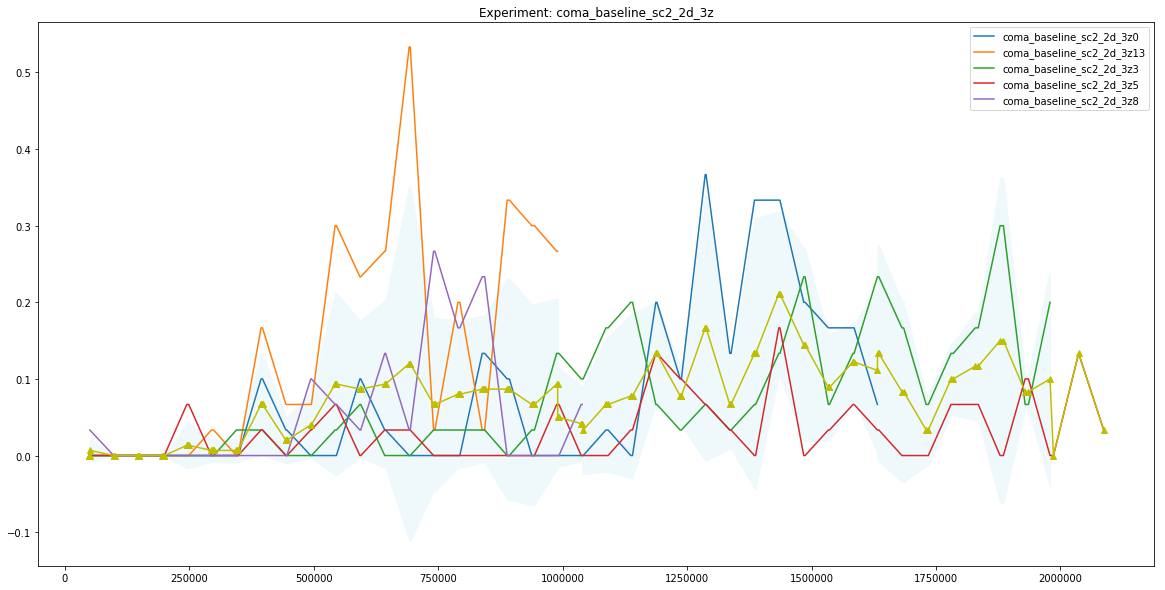

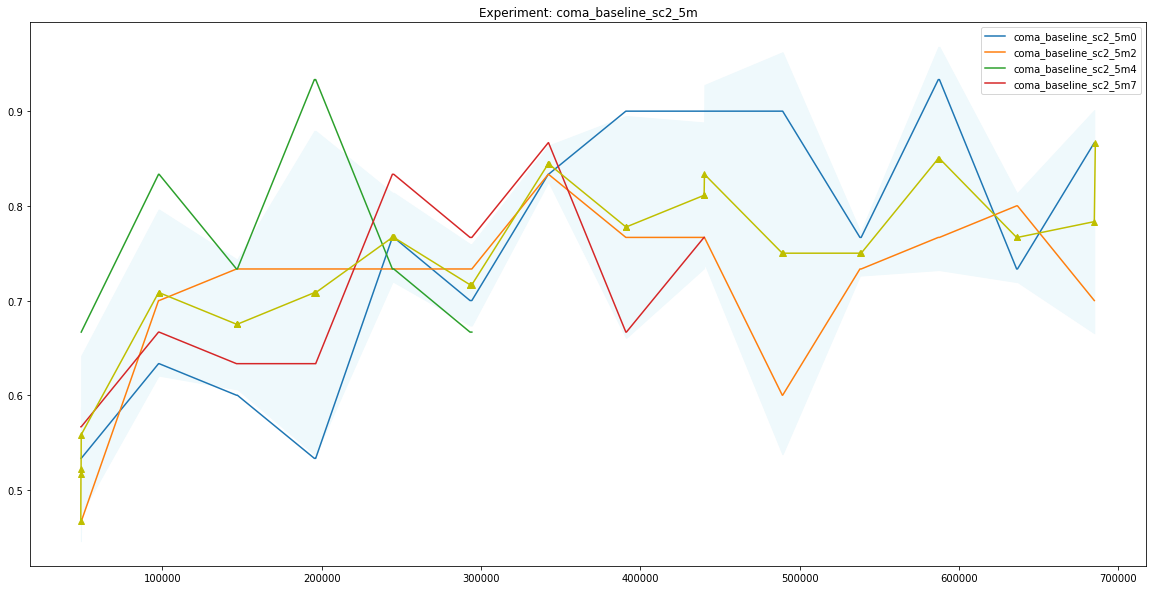

In [9]:
d2 = plot_bundle(b, mongo_central, prop="Win rate test", mode="individual")

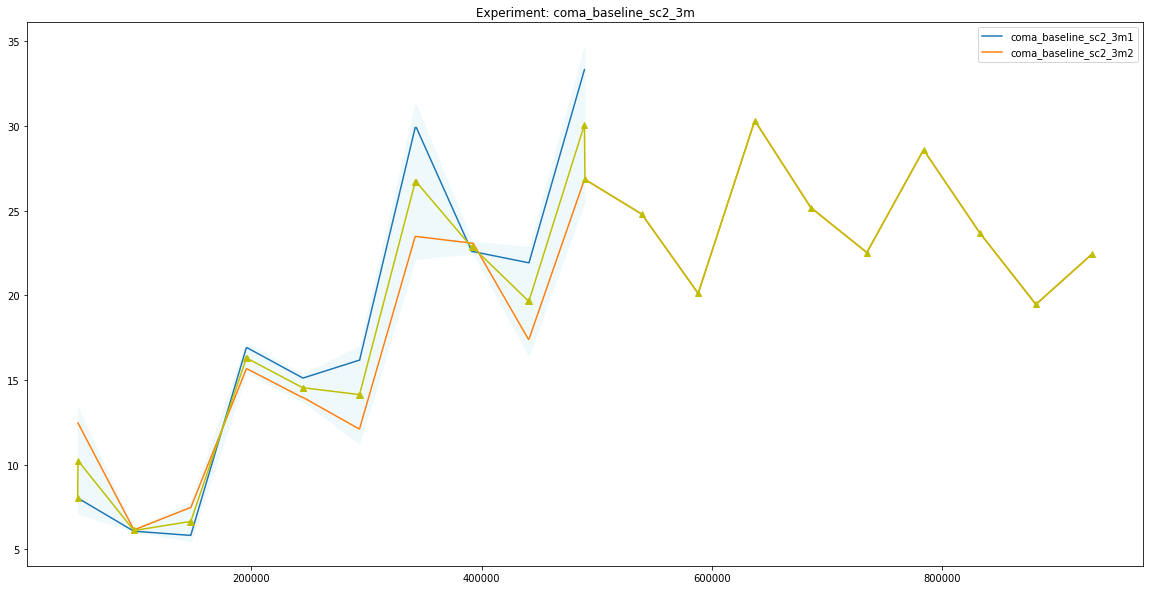

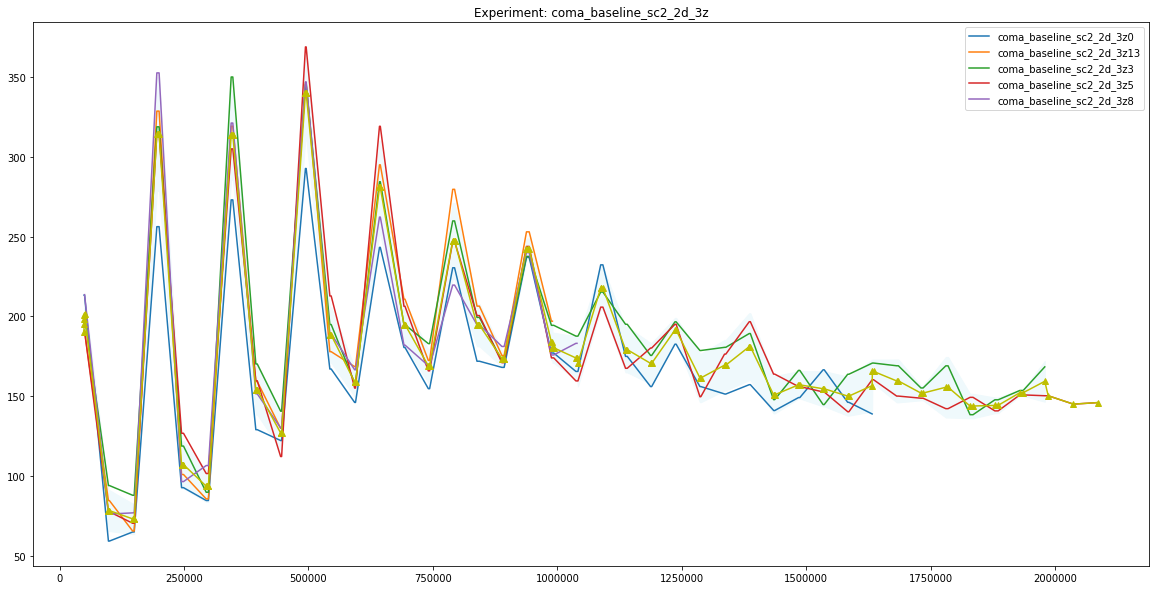

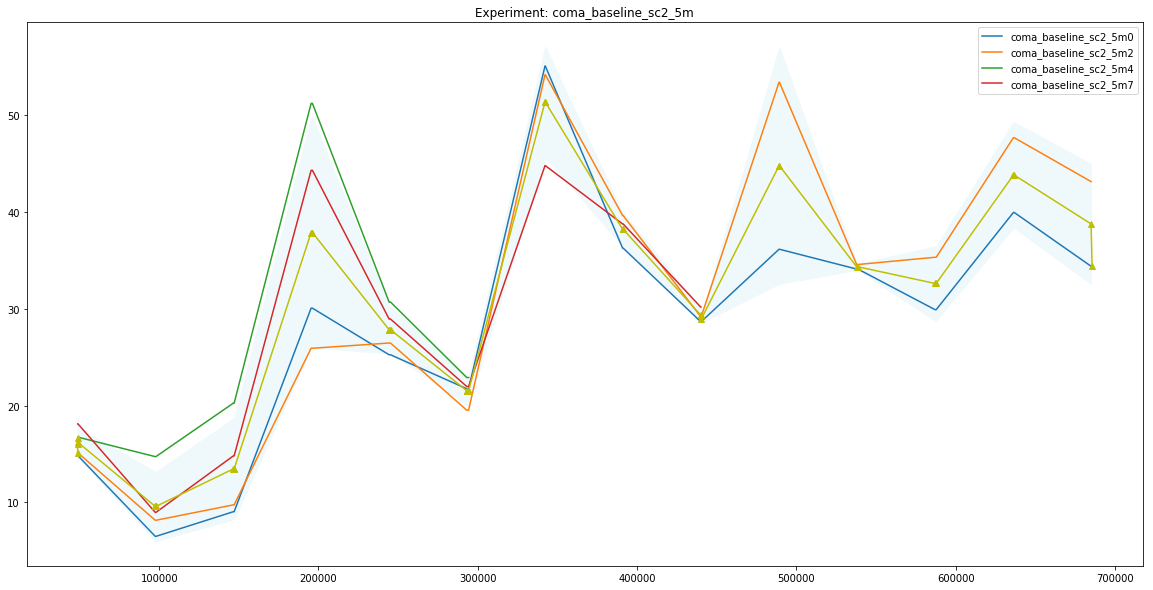

In [10]:
d3 = plot_bundle(b, mongo_central, prop="Critic loss", mode="individual")

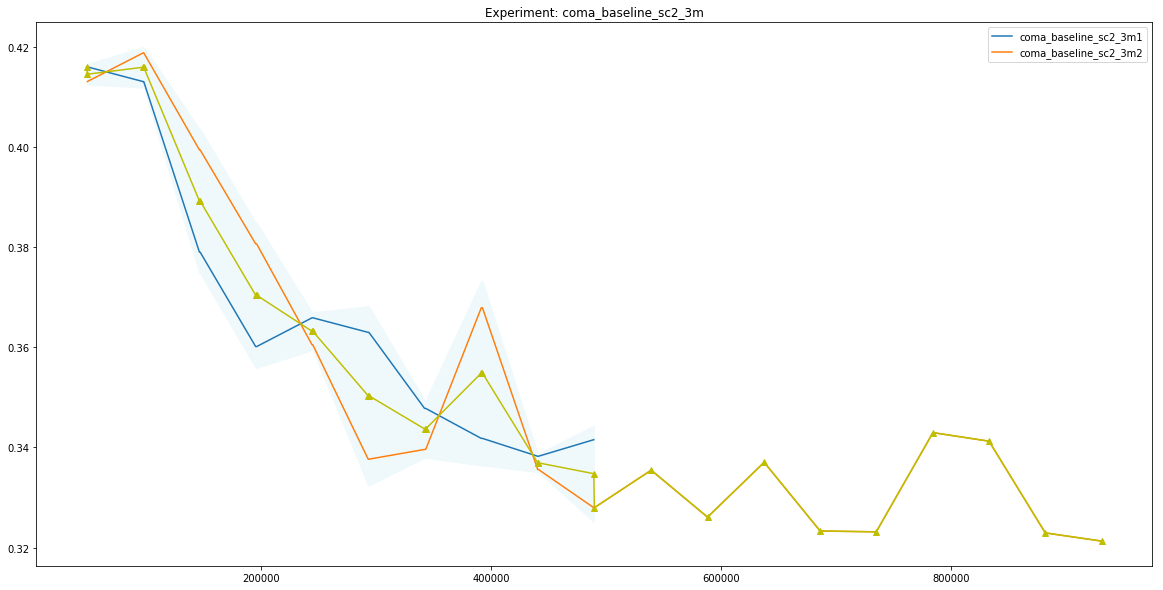

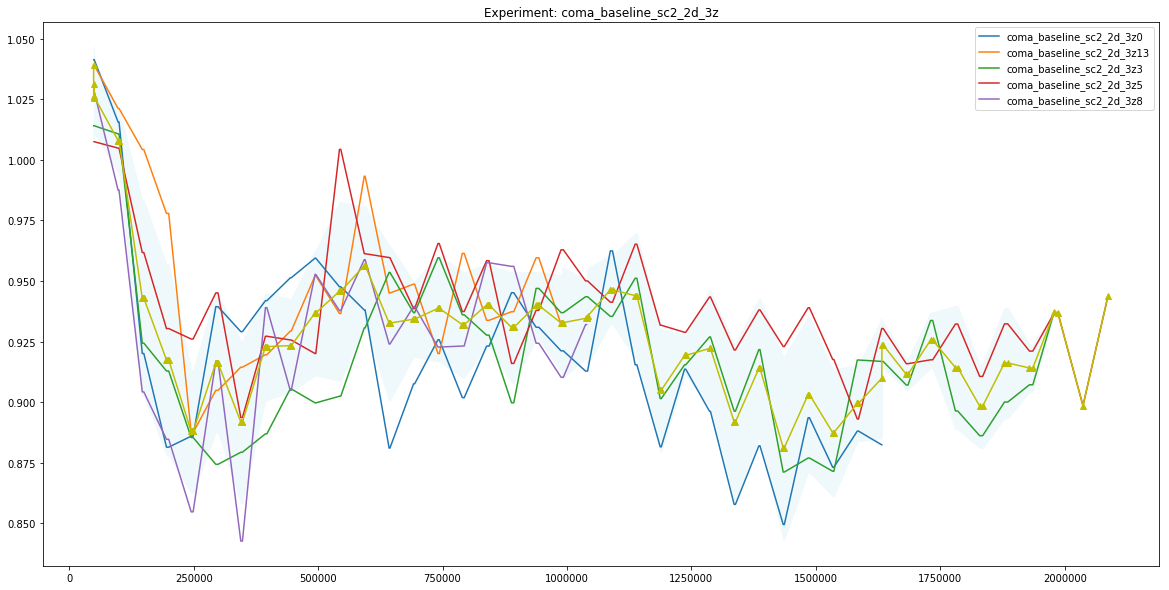

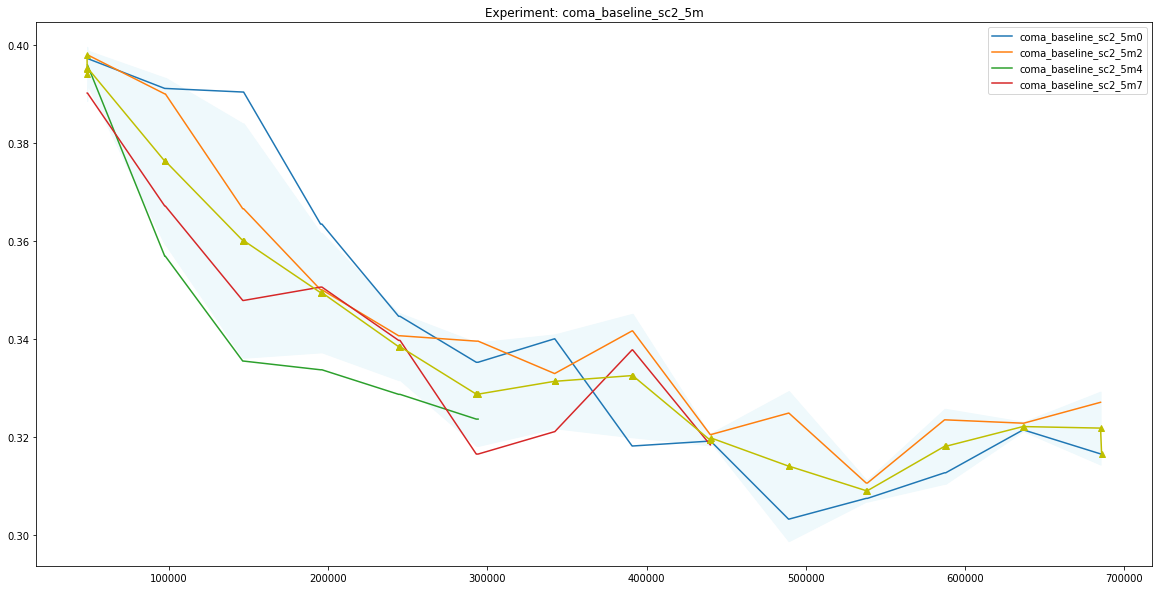

In [11]:
d4 = plot_bundle(b, mongo_central, prop="Policy entropy", mode="individual")

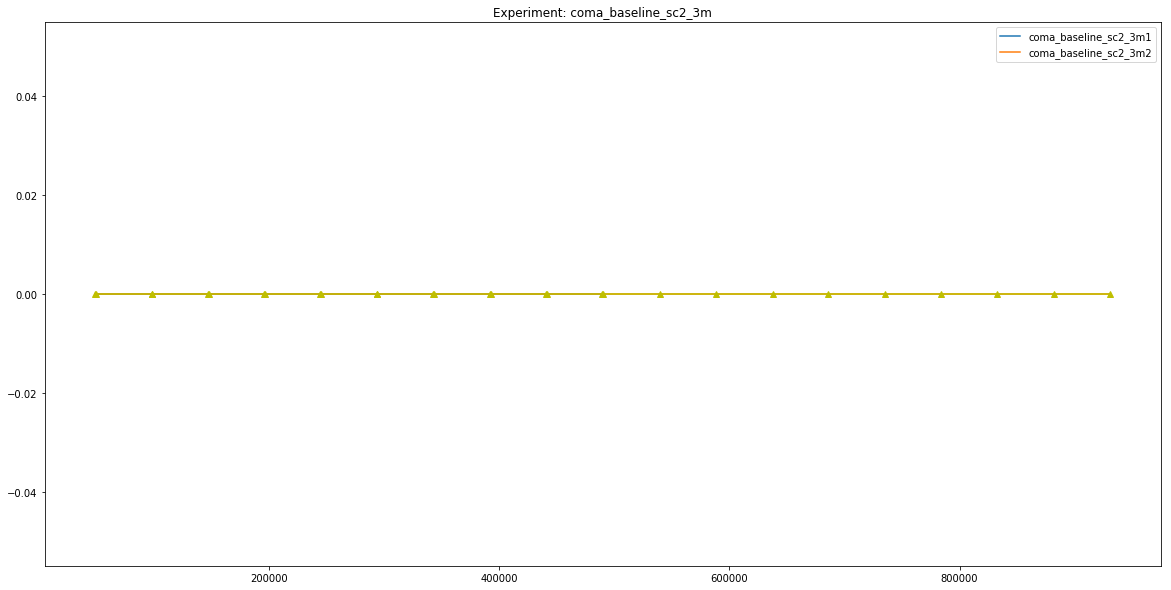

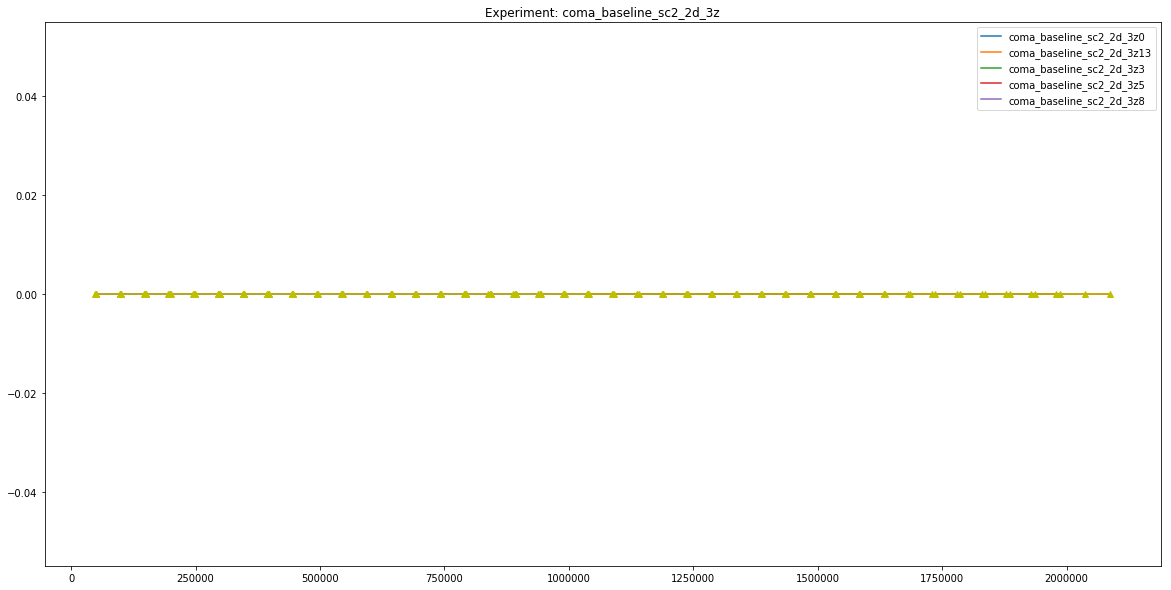

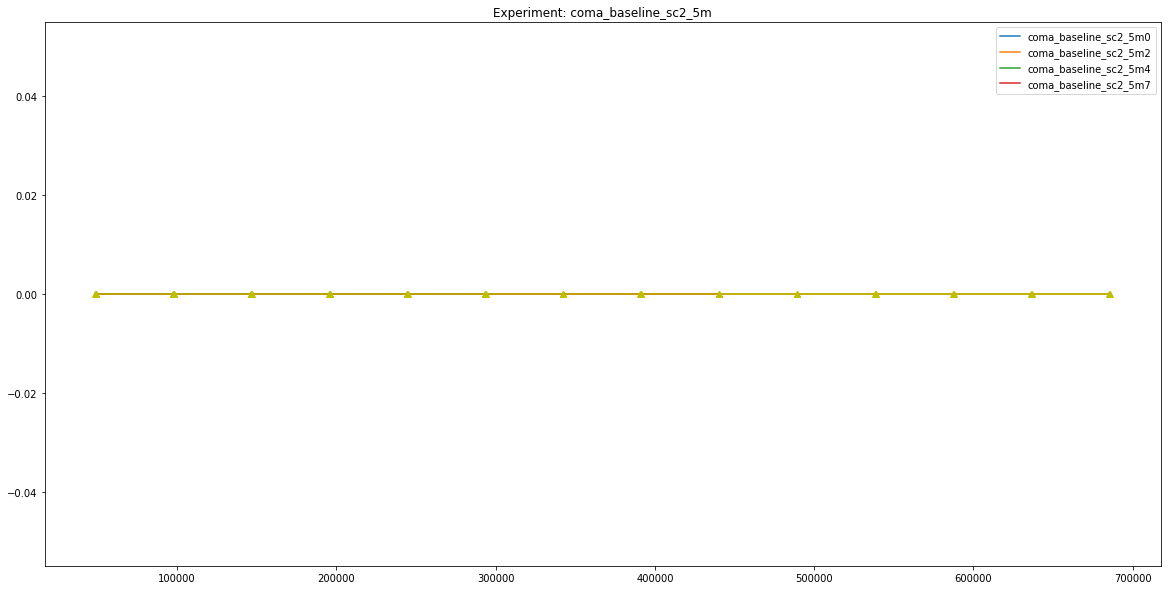

In [12]:
d6 = plot_bundle(b, mongo_central, prop="Win rate", mode="individual")

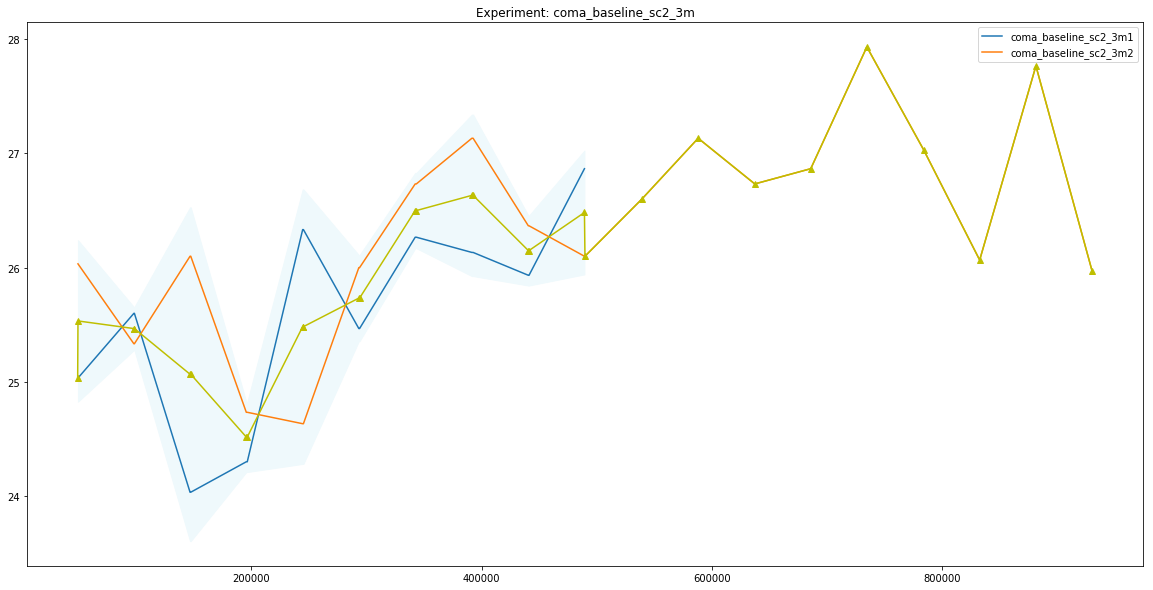

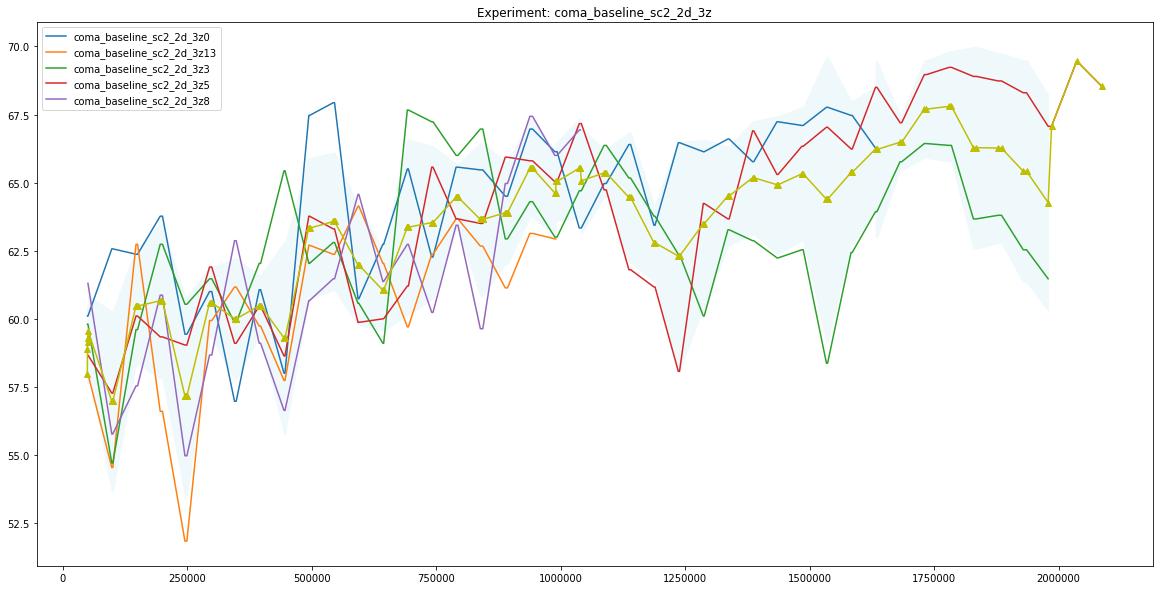

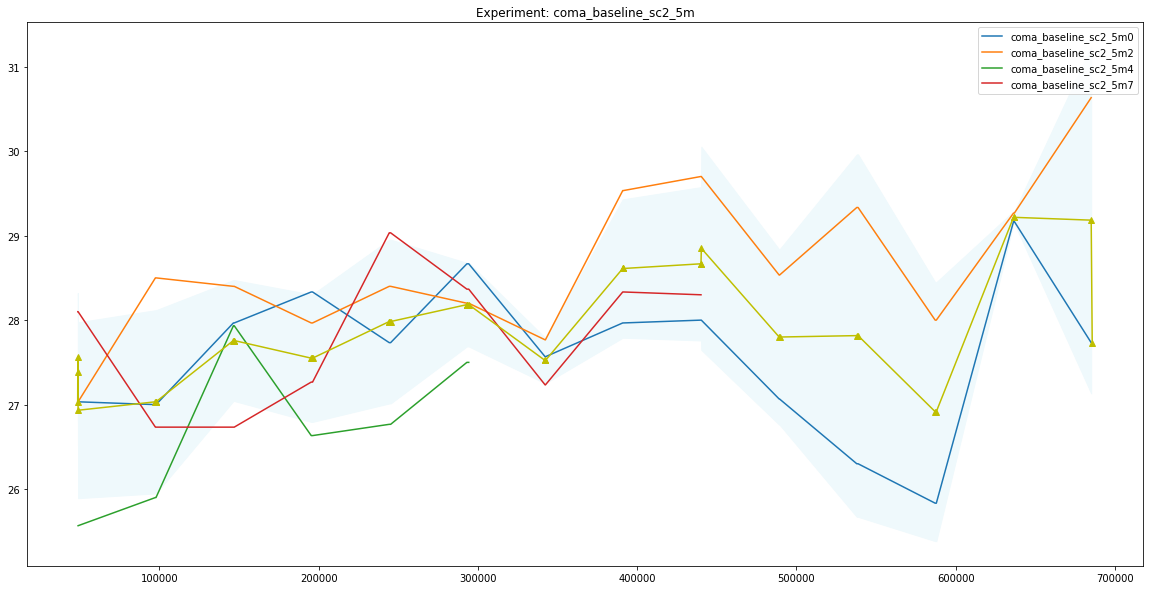

In [13]:
d7 = plot_bundle(b, mongo_central, prop="Episode length test", mode="individual")